# Тема работы: статистический анализ больших наборов текстовой информации

### **Структура работы:** 

1. Загрузка необходимых библиотек 
2. Загрузка датасета и анализ основных характеристик
3. Частотный анализ данных
4. Очистка данных и частотный анализ данных после предобработки
5. Векторизация текста 
6. Разбиение данных на обучающую, тестовую выборки 
7. Обучение моделей классификации 
8. Выводы о проделанных алгоритмах, выбор наиболее эффективного 
89. Визуализация результатов

1. Заргрузим необходимые библиотеки

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import nltk

2. Загрузим датасет:

In [11]:
df = pd.read_excel('spams.xlsx')
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Для удобства переименуем столбцы:

In [12]:
df = df.rename(columns={'v1':'label', 'v2':'message'})
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Выведем основную информацию о нем:

In [13]:
df.shape # размерность

(5565, 2)

In [14]:
df.describe()

,label,message
count,5565,5562
unique,3,5152
top,ham,"Sorry, I'll call later"
freq,4817,30


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5565 non-null   object
 1   message  5562 non-null   object
dtypes: object(2)
memory usage: 87.1+ KB


In [16]:
set(df['label'])

{'ham', 'ham"""', 'spam'}

In [17]:
df[df['label'] == 'ham"""']

,label,message
97,"ham""""""",NaN
2791,"ham""""""",Well there's still a bit left if you guys want...


Одна из меток не совсем правильно считалась, поэтому поправим это:

In [18]:
df['label'] = df['label'].replace('ham"""', 'ham')

In [19]:
df.groupby('label').describe().T

label                              ham  \
message count                     4816   
        unique                    4499   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 746  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

Сгруппировав по метке, видим, что обычных сообщений намного больше, чем спама.\
Самое частое обычное сообщение - это "Sorry, I'll call later", оно встречается 30 раз

Проверим на наличие пропусков:

In [20]:
df.isna().sum()

label      0
message    3
dtype: int64

В столбце с сообщениями есть пропущенные строки, поэтому уберем их:

In [21]:
df[df['message'].isna()]

,label,message
97,ham,NaN
1780,ham,NaN
3035,ham,NaN


In [22]:
df = df.dropna()

**3. Частотный анализ данных**

Посмотрим, сколько всего слов во всех сообщениях:

In [23]:
sum(df['message'].apply(lambda x: len(str(x).split( ))))

82882

Посчитаем и посмотрим на уникальные сообщения:

In [24]:
df['message'].value_counts().head()

Sorry, I'll call later                                          30
I cant pick the phone right now. Pls send a message             12
Ok...                                                           10
&lt                                                              7
House-Maid is the murderer, coz the man was murdered on  &lt     4
Name: message, dtype: int64

Создадим диаграмму распределения спам сообщений и сообщений без спама:

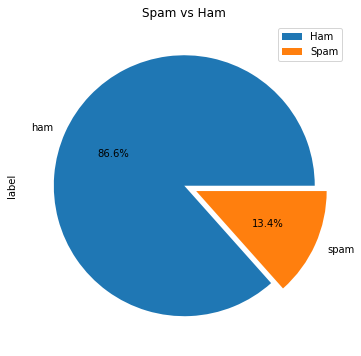

In [25]:
df["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%')
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"]);

Видим, что обычных сообщений сильно больше, чем спама.

Рассмотрим частотное распределение длины сообщения:

In [26]:
df['message'] = df['message'].apply(str)
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


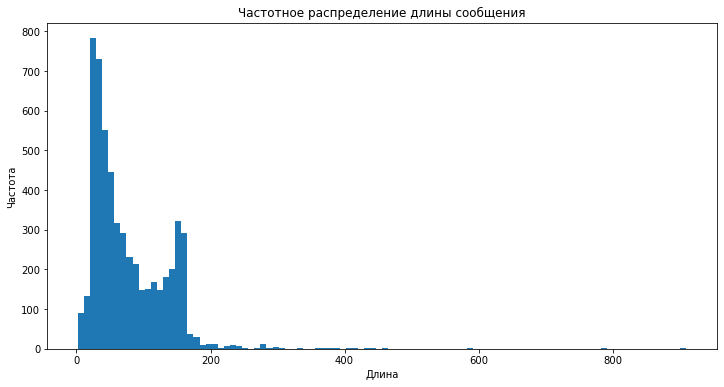

In [27]:
plt.figure(figsize=(12,6))
df['length'].plot(bins=100, kind='hist')
plt.title("Частотное распределение длины сообщения")
plt.xlabel("Длина")
plt.ylabel("Частота");

Чаще всего встречаются сообщения длиной в промежутке примерно от 2 до 180 симловов

In [28]:
df['length'].describe()

count    5562.000000
mean       76.561129
std        55.749223
min         2.000000
25%        34.000000
50%        58.000000
75%       115.000000
max       910.000000
Name: length, dtype: float64

Всего в датасете 5562 сообщения;\
Средняя длина сообщения составляет примерно 76.6 символов;\
Минимальная длина сообщения составляет 2 символа;\
Максимальная длина сообщения составляет 910 символов

Теперь посмотрим частотные распределения длин сообщений по отдельности:

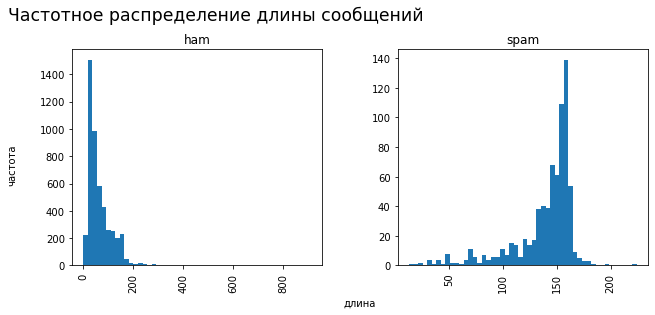

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
df.hist(column='length', by='label', bins=50,figsize=(40,50), ax=axes)
plt.suptitle('Частотное распределение длины сообщений', x=0.3, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.01, 'длина', ha='center')
fig.text(0.01, 0.5, 'частота', va='center', rotation='vertical');

In [30]:
df[['label', 'length']].groupby('label').describe()

length                                                          
        count        mean        std   min     25%    50%    75%    max
label                                                                  
ham    4816.0   66.931478  52.571600   2.0   32.00   50.0   87.0  910.0
spam    746.0  138.727882  29.451992  13.0  132.25  149.0  157.0  224.0

Теперь можно сравнить характеристики обычных сообщений и сообщений со спамом:\
средняя длина спам сообщения почти в два раза больше, чем средняя длина обычного сообщения;\
для сообщений со спамом характерно небольшое в сравнении с обычным сообщениями отклонение от средней длины;
минимальная длина сообщения со спамом выше, чем обычного;\
максимальная длина сообщения со спамом ниже, чем обычного

**4. Предобработка данных**

Сначала нужно подготовить текст к работе. \
Это включает в себя:
1. Приведение текста к нижнему регистру
2. Очистка от пунктуации
3. Очистка стоп-слов (то есть, те слова, которые наиболее часто встречаются) 
4. Токенизация

Заметим, что все сообщения в датасете являются предложениями на английском языке. 

In [31]:
stopwords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

In [32]:
print(stopwords[:5])
print(punctuation)

['i', 'me', 'my', 'myself', 'we']
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [33]:
spam_messages = df[df["label"] == "spam"]["message"]
ham_messages = df[df["label"] == "ham"]["message"]
#spam_messages.astype(str)

Напишем функцию $preprocess$_$text$, которая уберет все знаки пунктуации, стоп-слова, небуквенные символы и  приведет к нижнему регистру, и будет возвращать список подходящих значений

In [34]:
def remove_pun(text):
    text = re.sub(r'[^a-zA-Zа-яЁА-ЯЁ ]', '', text)
    text = text.lower()
    return ' '.join(list(set(text.split(' '))))

In [35]:
import re
def preprocess_text(df):
    def remove_pun(text):
        text = re.sub(r'[^a-zA-Zа-яЁА-ЯЁ ]', '', text)
        text = text.lower()
        return ' '.join(list(set(text.split(' '))))
    all_words = " ".join(df.apply(remove_pun)).split()
    nonstops = [word for word in all_words if word not in stopwords and word.isalpha()]
    return nonstops

In [36]:
spam_words = preprocess_text(spam_messages)

In [37]:
ham_words = preprocess_text(ham_messages)

Продолжим анализ данных уже после предобработки.

Посмотрим ТОП частых слов в спаме и нет.

Для спама:

In [38]:
from nltk.probability import FreqDist
spamdist = FreqDist(spam_words)
spamdist

FreqDist({'call': 319, 'е': 220, 'free': 169, 'txt': 142, 'u': 125, 'ur': 113, 'mobile': 109, 'claim': 108, 'text': 105, 'stop': 95, ...})

Частые слова: call, free, txt

Для обычных сообщений:

In [39]:
hamdist = FreqDist(ham_words)
hamdist

FreqDist({'u': 657, 'im': 405, 'get': 271, 'ok': 261, 'lt': 239, 'go': 224, 'ill': 218, 'got': 217, 'dont': 216, 'know': 212, ...})

Частые слова: u, im, get

Посмотрим на распределение слова в зависимости от их использование в тексте.

Спам:

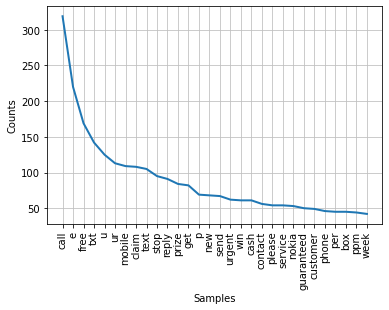

In [40]:
spamdist.plot(30,cumulative=False);

Обычные сообщения:

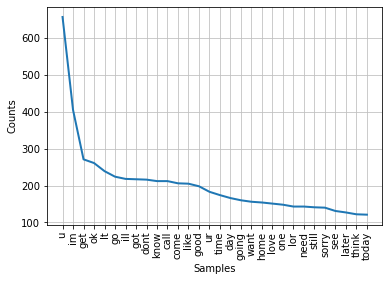

In [41]:
hamdist.plot(30,cumulative=False);

Создадим облако слов для наглядности:

In [42]:
from wordcloud import WordCloud

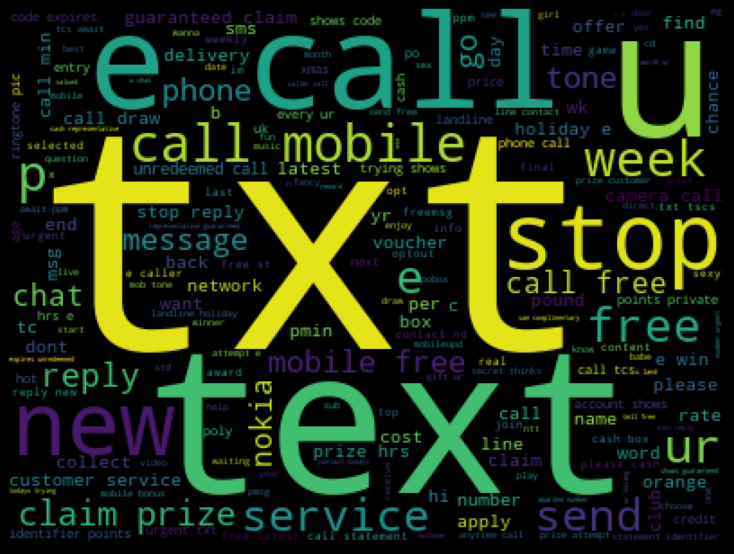

In [43]:
spam_wordcloud = WordCloud(width=400, height=300).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Неудивительно, что в спаме самые частые слова это: call, free, txt и др.

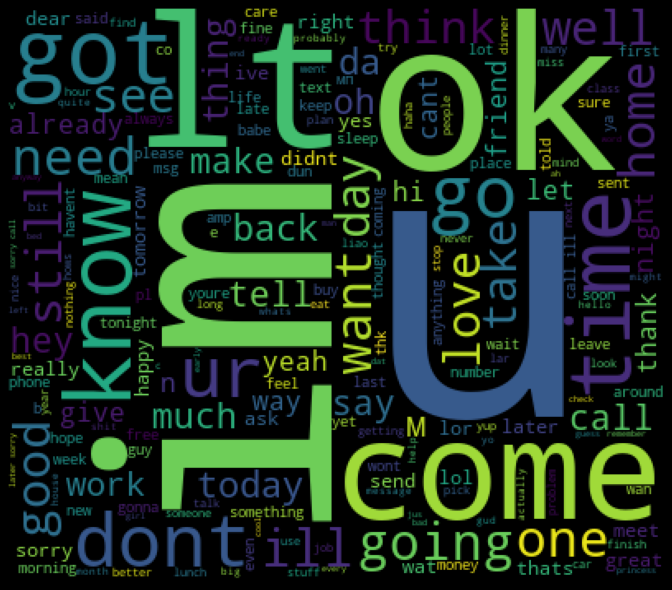

In [44]:
ham_wordcloud = WordCloud(width=400, height=350).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

В обычных сообщениях часто встречаются im, ok, u\
Здесь заметен эффект сленга: некоторые стоп-слова содержатся в видоизмененных формах и потому не убрались из данных.

В качестве примера классифицируем сообщения на спам и нет при помощи моделей классификации.

Преобразуем данные к удобному для классификацию типу данных:\
заменим строковые метки на численные и обработаем текстовые данные, убрав из них пунктуацию, небуквенные символы и стоп-слова.

In [45]:
df['label'] = df['label'].replace('ham', 0)
df['label'] = df['label'].replace('spam', 1)
df.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [46]:
def preprocess_text2(text):
    text = re.sub(r'[^a-zA-Zа-яЁА-ЯЁ ]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

In [47]:
df['message'] = df['message'].apply(preprocess_text2)

In [48]:
df.head()

,label,message,length
0,0,go jurong point crazy available bugis n great ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry wkly comp win fa cup final tkts st ...,155
3,0,u dun say early hor u c already say,49
4,0,nah dont think goes usf lives around though,61


В сообщениях много сокращений таких, как, например, 'idk', означающее 'i don't know'. Несмотря на большие возможности нормализации текста, ни стемминг, ни леммтизация в случае с сокращениями не поможет.\
Попробуем обучить модель, подав ей данные такие, какие мы получили на данном этапе.

**5. Векторизация**

Воспользуемся встроенным TF-IDF векторизатором:

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['message'])
vectors.shape

(5562, 8170)

In [50]:
features = vectors

**6. Разбиение данных на обучающую, тестовую выборки**

Теперь разобьем данные на обучающую и тестовую выборки в соотношении 80:20.

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=76)

In [52]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(4449, 8170)
(1113, 8170)
(4449,)
(1113,)


**7. Обучение моделей**

Для задачи классификации воспользуемся такими алгоритмами как:
1. Логистическая регрессия
2. Метод опорных векторов
3. k- ближайших соседей, где k=49
4. Наивный метод Байеса
5. Дерево решений
6. Случайный лес

Импортируем модели:

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

Воспользуемся конструктором класса для создания моделей:

In [54]:
svc = SVC(kernel='sigmoid')
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=72)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=72)

Создадим словарь с названиями моделей и самими моделями:

In [55]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}
def train(clf, features, targets):
    """обучает модели"""
    clf.fit(features, targets)

def predict(clf, features):
    """делает предсказания"""
    return (clf.predict(features))

В цикле обучим все модели и сохраним accuracy:

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    y_pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, accuracy_score(y_test , y_pred)))

**8. Выводы о проделанных алгоритмах, выбор наиболее эффективного**

Для удобного прочтения результатов создадим табличку со всеми результатами:

In [57]:
predictions = pd.DataFrame(pred_scores_word_vectors, columns=['model', 'score'])
predictions

,model,score
0,SVC,0.973046
1,KN,0.941599
2,NB,0.975741
3,DT,0.952381
4,LR,0.952381
5,RF,0.973944


Алгоритм наивного Байеса оказался наиболее удачным.

Проверим на переобучение модель:

In [61]:
mnb = MultinomialNB(alpha=0.2).fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_train_pred = mnb.predict(X_train)
print(f"Training score: {accuracy_score(y_train, y_train_pred)}")
print(f"Test score: {accuracy_score(y_test, y_pred)}")

Training score: 0.9941559901101371
Test score: 0.9757412398921833


Видно, что обе метрики имеют высокие показатели и между ними нет большого разрыва.\
Можно предположить, что переобучения нет.

**9. Визуализация результатов**

Посмотрим для самой удачной модели еще одну метрику:

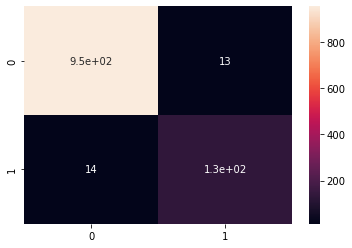

In [62]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True);

Учитывая объемы данных, можно утверждать, что модель достаточно хорошо классифицирует сообщения:\
на 950 правильно предсказанных обычных сообщений приходится 14 неправильно предсказаных. И на 130 правильно предсказанных спам-сообщений приходится 13 ошибки. Модель немного чаще ошибается в определении обычных сообщений, иногда классифицируя их как спам.

### Выводы

В ходе работы был проделан статистический анализ данных с сообщениями, где содержатся сообщения со спамом и без спама.\
Большую часть данных занимают сообщения без спама, они составляют 86,6% от всего датасета.\
Все длины сообщений находятся в диапазоне от 2 до 910 символов, а средняя длина сообщения составляет примерно 77 символов. Длинные сообщения, длиной свыше 224 символа, встречаются исключительно в обычных сообщениях.\
Короткие сообщения, длиной менее 13 символов, встречаются также исключительно в обычных сообщениях.\
Характерной чертой обычных сообщений является наличие сокращений и сленга. Эти же слова являются наиболее часто используемыми.
Для спам-сообщений характерны слова, призывающие перезвонить, написать, перейти по ссылке, слова, связанные с призом или подарком. На первом месте по частоте использования встречается слово "call" (позвонить). Не менее редкий является слово "free" (бесплатный), что неудивительно для сообщений со спамом.\

В качестве примера были обучены несколько моделей классификации. Среди них были: \
1. Логистическая регрессия
2. Метод опорных векторов
3. k- ближайших соседей
4. Наивный метод Байеса
5. Дерево решений
6. Случайный лес
Все они показали высокие метрики эффективности. Для дальнейшего анализа была выбрана модель с самой высокой метрикой эффективности - наивного Байеса, с accuracy = 0,975741.\
Модель показала хорошие результаты. Было выявлено, что  модель немного чаще ошибается в определении обычных сообщений, иногда классифицируя их как спам.